# Solving Problem of Rod with Distributed Forces Using PINNs

If distributed tensile forces **$cx$** exert on a rod, then the load at an elementary point $x$ is equivalent to 
$$\int_x^L cx \, dx = \frac{c}{2}(L^2 - x^2)$$ 
where $L$ is the total length of the rod, $c$ is the constant coefficient. The stresses on the rod are computed as 
$$\sigma = \displaystyle \frac{𝐿𝑜𝑎𝑑}{𝐴𝑟𝑒𝑎} = \displaystyle \frac{𝑐\space(L^2 −x^2)}{2A}$$ 
where $A$ is the cross-sectional area. In the rod subjected to axial loading, the strain is defined through the first derivative of the deformation (displacement) at a specific point 
$$\epsilon = \frac{du}{dx}$$ 
Here $u(x)$ is the displacement of the rod at point $x$. Further, as it is known the Young’s modulus (modulus of 
elasticity) is expressed as $E=\displaystyle \frac{\sigma}{\epsilon}$. Therefore, it follows that, $$AE\frac{du}{dx} = \frac{c}{2}(L^2-x^2)$$ Hence, 
$$AE\frac{d^2u}{dx^2} + cx = 0, x \in (0,L)$$
The bountry conditions for the fixed rod are
$$u(0) = 0, \quad \left. \frac{du}{dx} \right|_{x=L} = 0$$

### Exact Solution: 
$$u(x) = \frac{c}{6AE}(3L^2x - x^3)$$

## Part 1: Setup

In [3]:
#Installing tensorflow
!pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 1.2 MB/s eta 0:00:00
  Using cached tenso


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ----- ---------------------------------- 56.3/390.2 MB 5.5 MB/s eta 0:01:02
   ----- ---------------------------------- 56.5/390.2 MB 5.5 MB/s eta 0:01:02
   ----- ---------------------------------- 56.8/390.2 MB 5.5 MB/s eta 0:01:02
   ----- ---------------------------------- 57.1/390.2 MB 5.4 MB/s eta 0:01:02
   ----- ---------------------------------- 57.3/390.2 MB 5.5 MB/s eta 0:01:02
   ----- ---------------------------------- 57.6/390.2 MB 5.5 MB/s eta 0:01:01
   ----- ---------------------------------- 57.9/390.2 MB 5.4 MB/s eta 0:01:02
   ----- ---------------------------------- 58.2/390.2 MB 5.5 MB/s eta 0:01:01
   ----- ---------------------------------- 58.5/390.2 MB 5.5 MB/s eta 0:01:01
   ------ --------------------------------- 58.7/390.2 MB 5.5 MB/s eta 0:01:01
   ------ --------------------------------- 59.0/390.2 MB 5.5 MB/s eta 0:01:01
   ------ --------------------------------- 59.3/390.2 MB 5.5 MB/s eta 0:01:01
   ------ --------------------------------- 59.5/390

In [1]:
# Importing necessary libraries:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.optimize import minimize

In [2]:
# Checking tensorflow installation
print(tf.__version__)

2.18.0


In [5]:
# Defining constants:
A = 1.0 # Cross-sectional area
E = 1.0 # Modulus of elasticity
c = 1.0 # Load distribution constant
L = 1.0 # Length of rod

# Define boundary conditions:
def boundary_conditions(x):
    return np.array([0, 0]) # [u(0), du/dx(L)]

## Part 2: Creating the Model

### Defining the Neural Network:
* **Input layer:** single coordinate $x$
* **Hidden layers:** creating the model with 2 hidden layers
* **Output Layer:** single output $u(x)$

In [6]:
class PINN(tf.keras.Model):
    def __init__(self, layers):
        # Initialize the layers
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(layer, activation='tanh') for layer in layers]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)
        
    def build(self, input_shape):
        # Manually build each layer to ensure proper initialization
        for layer in self.hidden_layers:
            layer.build(input_shape)
            input_shape = (input_shape[0], layer.units)
        self.output_layer.build(input_shape)
        super(PINN, self).build(input_shape)

    def call(self, x):
        # Forward pass through the network
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)
    
# Define the model with 2 hidden layers
model = PINN(layers=[10, 10])

### Loss Function:

In [7]:
def loss(model, x):
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape2.watch(x)
            u = model(x)
        u_x = tape.gradient(u, x)
#         tf.print("First Derivative:", u_x)
    u_xx = tape2.gradient(u_x, x)
#     tf.print("Second Derivative: ", u_xx)
    
    # Check if gradients are None and set them to zero if they are 
#     if u_xx is None: 
#         u_xx = tf.zeros_like(x)

    residual = A * E * u_xx + c * x
    residual = tf.reduce_mean(tf.square(residual))
#     tf.print("Residual loss:", residual)
    
    # Also compute boundary loss with None checks
    u_at_0 = model(tf.zeros((1,1)))
#     tf.print("Model Output at x = 0:", u_at_0)
#     if u_at_0 is None:
#         u_at_0 = tf.zeros(1)
        
    x_L = tf.constant([[L]])    
    with tf.GradientTape() as tape:
        tape.watch(x_L)
        u_at_L = model(x_L)
        grad_u_at_L = tape.gradient(u_at_L, x_L)
#     tf.print("Gradient at x = L:", grad_u_at_L)
#     if grad_u_at_L is None:
#         grad_u_at_L = tf.zeros(1)
        
    boundary_loss = tf.reduce_mean(tf.square(u_at_0)) + tf.reduce_mean(tf.square(grad_u_at_L))
#     tf.print("Boundary loss: ", boundary_loss)
    return residual + boundary_loss

## Part 3: Training the Model

### Collocation Points:
We choose 100 evenly spaced points between 0 and L

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(model, x):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x)
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return current_loss

loss_history = [] # Store the loss at each epoch 

# Training model and storing loss
epochs = 1000
x = tf.linspace(0.0, L, 100)[:, None]
for epoch in range(epochs):
    current_loss = train_step(model, x)
    loss_history.append(current_loss.numpy())
    if (epoch%100==0):
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")
    if (epoch == 999):
        print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

Epoch 0: Loss = 0.5772567987442017
Epoch 100: Loss = 0.1515071541070938
Epoch 200: Loss = 0.021284116432070732
Epoch 300: Loss = 0.013008369132876396
Epoch 400: Loss = 0.005576727911829948
Epoch 500: Loss = 0.0013574204640462995
Epoch 600: Loss = 0.0006140402401797473
Epoch 700: Loss = 0.00035353691782802343
Epoch 800: Loss = 0.00023332193086389452
Epoch 900: Loss = 0.00018637286848388612
Epoch 999: Loss = 0.00016831864195410162


## Part 4: Visualising the Solution

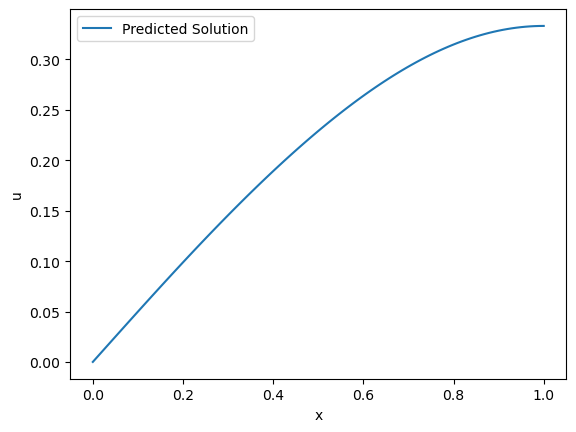

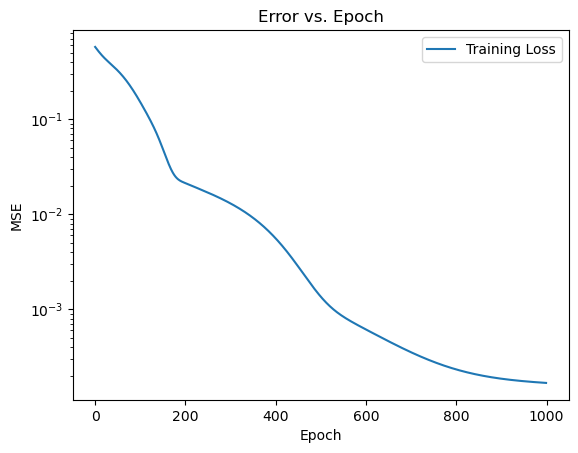

In [37]:
# u vs x graph
x_test = tf.linspace(0.0, L, 100)[:, None]
u_pred = model(x_test)

plt.plot(x_test.numpy(), u_pred.numpy(), label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

# Error vs epoch graph
# loss_history = [item[0][0] for item in loss_history]
plt.semilogy(range(epochs), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Error vs. Epoch')
plt.legend()
plt.show()


## Part 5: Further Optimization of the Model

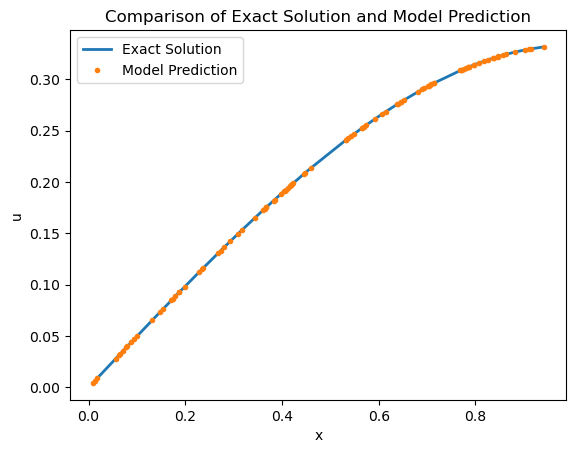

In [36]:
x_random = np.random.uniform(0, L, 100)

u_exact = (((3 * x_random * L**2) - (x_random**3)) * c) / (6 * A * E)

# for x, u in zip(x_random, u_exact): 
#     print(f"x: {x:.4f}, u_exact: {u:.4f}")

# Convert x_random to a tensor for model prediction 
x_random_tensor = tf.constant(x_random, dtype=tf.float32)
x_random_tensor = tf.expand_dims(x_random_tensor, axis=-1)

# Compute u_model(x) using the trained model 
u_model = model(x_random_tensor).numpy().flatten()

# Sorting for a line plot
sorted_indices = np.argsort(x_random) 
x_sorted = x_random[sorted_indices]
u_exact_sorted = u_exact[sorted_indices]

plt.plot(x_sorted, u_exact_sorted, label='Exact Solution', linewidth=2)
plt.plot(x_random, u_model, 'o', label='Model Prediction', markersize=3)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Comparison of Exact Solution and Model Prediction') 
plt.legend()
plt.show()